Pertama import library yang akan dipake

In [2]:
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score
import copy
import warnings
import matplotlib.pyplot as plt
import pandas as pd
import csv
import random
random.seed(42) #agar hasil random bisa konsisten 
warnings.filterwarnings('ignore')

<h2>Import dan Cleaning Data</h2>

In [3]:
df = pd.read_csv("datasets/udara.data.csv", header=None)
df.rename(columns={0:"PM10", 1:"SO2", 2:"O3", 3:"NO2", 4:"CO"}, inplace=True)
df["SO2"] = df["SO2"].astype(float)
df["CO"] = df["CO"].astype(float)
df.head()

,PM10,SO2,O3,NO2,CO
0,13.83,4.54,5.46,0.54,0.33
1,6.44,0.00,3.11,0.00,0.00
2,0.00,0.00,0.00,0.00,0.00
3,0.00,0.00,0.00,0.00,0.00
4,0.00,0.00,0.00,0.00,0.00


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 365 entries, 0 to 364
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   PM10    365 non-null    float64
 1   SO2     365 non-null    float64
 2   O3      365 non-null    float64
 3   NO2     365 non-null    float64
 4   CO      365 non-null    float64
dtypes: float64(5)
memory usage: 14.4 KB


In [5]:
data = df[["O3", "CO"]]
data = data.values
print(data)

[[ 5.46    0.33  ]
 [ 3.11    0.    ]
 [ 0.      0.    ]
 [ 0.      0.    ]
 [ 0.      0.    ]
 [ 0.      0.    ]
 [ 0.      0.    ]
 [ 0.      0.    ]
 [ 0.      0.    ]
 [ 0.      0.    ]
 [ 3.37    6.68  ]
 [ 3.67    6.    ]
 [ 4.      4.38  ]
 [ 4.46    6.33  ]
 [ 4.63    8.04  ]
 [ 4.     10.25  ]
 [ 4.      7.46  ]
 [ 4.58    8.33  ]
 [ 5.     10.5   ]
 [ 5.54   28.63  ]
 [ 6.     32.    ]
 [ 5.96   29.17  ]
 [ 5.     11.42  ]
 [ 4.92    9.    ]
 [ 2.58   12.38  ]
 [ 2.     16.5   ]
 [ 2.83   19.46  ]
 [ 3.     21.71  ]
 [ 3.     27.54  ]
 [ 3.     29.58  ]
 [ 3.     27.79  ]
 [ 3.     27.08  ]
 [ 3.     28.83  ]
 [ 3.     28.83  ]
 [ 3.     31.08  ]
 [ 3.     30.71  ]
 [ 3.     30.    ]
 [ 3.     30.46  ]
 [ 3.     31.    ]
 [ 3.67   31.    ]
 [ 4.     31.33  ]
 [ 4.     32.    ]
 [ 4.     32.    ]
 [ 0.      0.    ]
 [ 0.      0.    ]
 [ 2.77   31.    ]
 [ 3.     32.    ]
 [ 3.     32.    ]
 [ 0.      0.    ]
 [ 0.      0.    ]
 [ 0.      0.    ]
 [ 0.      0.    ]
 [ 4.79   32

<h2>Percobaan langsung menggunakan K-Means</h2>

Disini parameter pada K-means ditentukan secara random oleh penulis

In [6]:
kmeans = KMeans(n_clusters=5, init='random', max_iter=10)
kmeans.fit(data)

KMeans(init='random', max_iter=10, n_clusters=5)

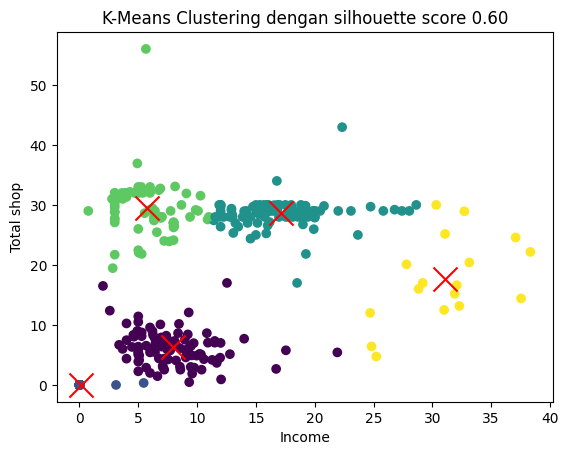

In [7]:
cluster_assignments = kmeans.labels_
plt.scatter(data[:, 0], data[:, 1], c=cluster_assignments, cmap='viridis')
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s=300, c='red', marker='x')
plt.xlabel('Income')
plt.ylabel('Total shop')
plt.title(f'K-Means Clustering dengan silhouette score {silhouette_score(data, cluster_assignments):.2f}')
plt.show()

<h2>Percobaan dengan ABC Algorithm dengan objective function menggunakan nilai Silhoutte score</h2>

buat objective function

disini variabel yang akan diuji adalah nilai silhouette yang nanti akan dimaksimumkan, dimana makin tinggi nilai silhouette maka kesesuaian data pada sebuah klaster semakin baik

In [8]:
def objective_function_silhoutte(params, data):
    n_clusters, init, max_iter = params
    kmeans = KMeans(n_clusters=n_clusters, init=init, max_iter=max_iter)
    kmeans.fit(data)
    labels = kmeans.labels_ #hasil klaster
    return silhouette_score(data, labels)

tentukan parameter untuk menjalankan ABC algorithm

In [9]:
# Parameter ABC
n_employed_bees = 50
n_onlooker_bees = 50
n_scout_bees = 50
max_iterations = 100

import data dan jadikan sebagai Array

In [10]:
#df = pd.read_csv("datasets/customer/marketing_campaign.csv", sep='\t')
#df.head()
#df = df.dropna()

In [11]:
df.head()

,PM10,SO2,O3,NO2,CO
0,13.83,4.54,5.46,0.54,0.33
1,6.44,0.00,3.11,0.00,0.00
2,0.00,0.00,0.00,0.00,0.00
3,0.00,0.00,0.00,0.00,0.00
4,0.00,0.00,0.00,0.00,0.00


buat batasan parameter yang akan diuji, karena input parameter yang bsia diubah adalah jumlah klaster, mode inisialisasi dan total iterasi, maka ketiga variabel tadi yang akan diuji

In [12]:
param_range = {
    'n_clusters': list(range(2, 11)),  # buat nyoba jumlah cluster yang terbaik ada berapa
    'init': ['k-means++', 'random'],   # buat nyoba metode inisialisasi K-means yang terbaik gimana
    'max_iter': list(range(100, 501, 100))  # maximum iterasi K-means
}

ABC = searching algorithm yang make konsep seperti lebah, jadi nanti dia akan ngekeep parameter terbaik sampai parameter yang lebih baik ditemukan

In [13]:
#employed bee == yang nyari
employed_bees = []
for _ in range(n_employed_bees):
    params = [np.random.choice(param_range['n_clusters']),
              np.random.choice(param_range['init']),
              np.random.choice(param_range['max_iter'])]
    employed_bees.append((params, objective_function_silhoutte(params, data)))

employed bee akan nyari parameter secara acak dari list parameter yang ada, 20 titik ini akan jadi titik inisialisasi untuk melihat titik terbaik

In [14]:
#dibawah ini contoh hasil yagn didapat, ini digunakan sebagai inisialisasi kemudian nantinya akan dicompare dengan hasil algoritma ABC
employed_bees

[([2, 'k-means++', 100], 0.6639153184611662),
 ([10, 'k-means++', 400], 0.49364113748400085),
 ([10, 'random', 500], 0.4939916464981199),
 ([7, 'random', 500], 0.5340821327911048),
 ([3, 'random', 200], 0.5819768136034068),
 ([8, 'random', 100], 0.5235201693461695),
 ([7, 'k-means++', 200], 0.5678393017188994),
 ([5, 'random', 300], 0.5970930726055329),
 ([6, 'random', 200], 0.5356259066594247),
 ([5, 'k-means++', 400], 0.5973525111347628),
 ([7, 'k-means++', 400], 0.5573789056068785),
 ([4, 'k-means++', 400], 0.6205101491124468),
 ([2, 'random', 500], 0.6639153184611662),
 ([10, 'random', 300], 0.49853263350372035),
 ([7, 'random', 200], 0.5673886762211328),
 ([9, 'k-means++', 300], 0.518389348986611),
 ([9, 'k-means++', 100], 0.5372290671253696),
 ([4, 'random', 100], 0.6213379058914843),
 ([8, 'random', 500], 0.5591195978674829),
 ([3, 'k-means++', 300], 0.5819768136034068),
 ([4, 'k-means++', 100], 0.6209305825786275),
 ([5, 'k-means++', 100], 0.5973525111347628),
 ([4, 'random', 5

dicari titik terbaik dari list titik-titik tadi

In [15]:
best_solution = max(employed_bees, key=lambda x: x[1]) #disini bisa dilihat bahwa yang dilihat adalah silhouette scorenya
best_solution_params, best_solution_value = best_solution
best_solution

([2, 'k-means++', 100], 0.6639153184611662)

konsep dari ABC ini adalah

pertama pada phase employed bees, 
akan dicek semua hasil dari si employed bees, dan parameter yang udah didapetin sebelumnya, akan diubah-ubah lagi dan akan dibandingkan dengan hasil terbaik yang udah didapetin sebelumnya. apabila lebih baik, maka titik dari si employed bee tadi akan diganti dengan yang baru, dan ini akan diulan-ulang

pada phase onlooker bees,
pertama akan ditotal dulu silhouette scorenya dan akan dicari yang scorenya kecil, score kecil ini akan ditinjau ulang dengan mencari ulang parameter sampai nilai yang didapatin bisa lebih baik

Pada phase scout bees,
akan dicari mana parameter yang silhouette scorenya terbaik.

semua ini akan diulangi hingga max_iteration


In [16]:
for iteration in range(max_iterations):
    # Employed Bee Phase
    for i in range(n_employed_bees):
        params, _ = employed_bees[i]
        neighbor_params = copy.deepcopy(params)
        param_to_change = np.random.choice(3)  
        neighbor_params[param_to_change] = np.random.choice(param_range[list(param_range.keys())[param_to_change]])
        neighbor_value = objective_function_silhoutte(neighbor_params, data)
        if neighbor_value > employed_bees[i][1]:
            employed_bees[i] = (neighbor_params, neighbor_value)

    # Onlooker Bee Phase
    onlooker_bees = []
    total_value = sum(bee[1] for bee in employed_bees)

    for i in range(n_onlooker_bees):
        random_index = np.random.choice(len(employed_bees))
        selected_bee = employed_bees[random_index]
        onlooker_bees.append(selected_bee)
        total_value += selected_bee[1]

    for i in range(n_onlooker_bees):
        if np.random.rand() < (onlooker_bees[i][1] / total_value):
            params, _ = onlooker_bees[i]
            neighbor_params = copy.deepcopy(params)
            param_to_change = np.random.choice(3)
            neighbor_params[param_to_change] = np.random.choice(param_range[list(param_range.keys())[param_to_change]])
            neighbor_value = objective_function_silhoutte(neighbor_params, data)
            if neighbor_value > onlooker_bees[i][1]:
                onlooker_bees[i] = (neighbor_params, neighbor_value)

    # Scout Bee Phase
    for i in range(n_employed_bees):
        if employed_bees[i][1] == best_solution_value:
            params = [np.random.choice(param_range['n_clusters']),
                      np.random.choice(param_range['init']),
                      np.random.choice(param_range['max_iter'])]
            employed_bees[i] = (params, objective_function_silhoutte(params, data))

    # Update best solution
    best_solution = max(employed_bees, key=lambda x: x[1])
    best_solution_params, best_solution_value = best_solution

In [17]:
print("Best Parameters:", best_solution_params)
print("Best Silhouette Score:", best_solution_value)

Best Parameters: [2, 'k-means++', 200]
Best Silhouette Score: 0.6639153184611662


In [18]:
kmeans = KMeans(n_clusters=best_solution_params[0], init=best_solution_params[1], max_iter=best_solution_params[2])
kmeans.fit(data)

KMeans(max_iter=200, n_clusters=2)

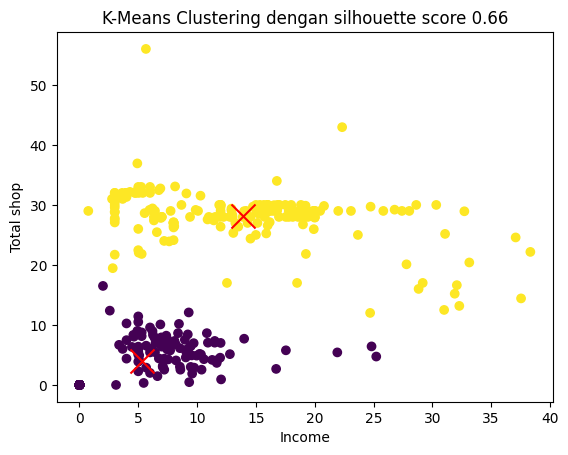

In [19]:
cluster_assignments = kmeans.labels_
plt.scatter(data[:, 0], data[:, 1], c=cluster_assignments, cmap='viridis')
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s=300, c='red', marker='x')
plt.xlabel('Income')
plt.ylabel('Total shop')
plt.title(f'K-Means Clustering dengan silhouette score {silhouette_score(data, cluster_assignments):.2f}')
plt.show()

<h2>Percobaan Menggunakan ABC Algorithm dengan Objective Function Davies Bouldin Score Objective Function</h2>

pada metric ini, semakin kecil nilainya maka akan semakin baik

In [20]:
def objective_function_DBS(params, data):
    n_clusters, init, max_iter = params
    kmeans = KMeans(n_clusters=n_clusters, init=init, max_iter=max_iter)
    kmeans.fit(data)
    labels = kmeans.labels_ #hasil klaster
    return davies_bouldin_score(data, labels)

In [21]:
#employed bee == yang nyari
employed_bees = []
for _ in range(n_employed_bees):
    params = [np.random.choice(param_range['n_clusters']),
              np.random.choice(param_range['init']),
              np.random.choice(param_range['max_iter'])]
    employed_bees.append((params, objective_function_DBS(params, data)))

In [22]:
employed_bees

[([9, 'k-means++', 200], 0.7057634284395355),
 ([9, 'random', 100], 0.6336710060255027),
 ([8, 'k-means++', 100], 0.7962718586822665),
 ([9, 'k-means++', 500], 0.6437140390651516),
 ([10, 'random', 200], 0.7266085368524141),
 ([8, 'random', 100], 0.6761308745051575),
 ([2, 'k-means++', 300], 0.4944982972986976),
 ([7, 'random', 500], 0.6763092376154969),
 ([7, 'k-means++', 200], 0.6853318620648705),
 ([7, 'k-means++', 300], 0.6925292741942136),
 ([7, 'k-means++', 100], 0.7468830582588665),
 ([7, 'random', 300], 0.6464766630195576),
 ([5, 'random', 100], 0.5681187703484507),
 ([7, 'k-means++', 200], 0.6531270974331514),
 ([10, 'random', 400], 0.6747807206154032),
 ([5, 'random', 100], 0.5539424968958715),
 ([2, 'k-means++', 500], 0.4944982972986976),
 ([8, 'random', 500], 0.6984190873149452),
 ([4, 'k-means++', 100], 0.5684861078752794),
 ([7, 'random', 200], 0.6797071713690495),
 ([6, 'k-means++', 100], 0.6005050916353508),
 ([6, 'k-means++', 300], 0.6043195797841768),
 ([5, 'k-means++

In [23]:
best_solution = max(employed_bees, key=lambda x: x[1]) #disini bisa dilihat bahwa yang dilihat adalah silhouette scorenya
best_solution_params, best_solution_value = best_solution
best_solution

([9, 'random', 100], 0.806980325606555)

In [24]:
for iteration in range(max_iterations):
    # Employed Bee Phase
    for i in range(n_employed_bees):
        params, _ = employed_bees[i]
        neighbor_params = copy.deepcopy(params)
        param_to_change = np.random.choice(3)  
        neighbor_params[param_to_change] = np.random.choice(param_range[list(param_range.keys())[param_to_change]])
        neighbor_value = objective_function_DBS(neighbor_params, data)
        if neighbor_value < employed_bees[i][1]:
            employed_bees[i] = (neighbor_params, neighbor_value)

    # Onlooker Bee Phase
    onlooker_bees = []
    total_value = sum(bee[1] for bee in employed_bees)

    for i in range(n_onlooker_bees):
        random_index = np.random.choice(len(employed_bees))
        selected_bee = employed_bees[random_index]
        onlooker_bees.append(selected_bee)
        total_value += selected_bee[1]

    for i in range(n_onlooker_bees):
        if np.random.rand() < (onlooker_bees[i][1] / total_value):
            params, _ = onlooker_bees[i]
            neighbor_params = copy.deepcopy(params)
            param_to_change = np.random.choice(3)
            neighbor_params[param_to_change] = np.random.choice(param_range[list(param_range.keys())[param_to_change]])
            neighbor_value = objective_function_DBS(neighbor_params, data)
            if neighbor_value < onlooker_bees[i][1]:
                onlooker_bees[i] = (neighbor_params, neighbor_value)

    # Scout Bee Phase
    for i in range(n_employed_bees):
        if employed_bees[i][1] == best_solution_value:
            params = [np.random.choice(param_range['n_clusters']),
                      np.random.choice(param_range['init']),
                      np.random.choice(param_range['max_iter'])]
            employed_bees[i] = (params, objective_function_DBS(params, data))

    # Update best solution
    best_solution = min(employed_bees, key=lambda x: x[1])
    best_solution_params, best_solution_value = best_solution

In [25]:
print("Best Parameters:", best_solution_params)
print("Best Silhouette Score:", best_solution_value)

Best Parameters: [5, 'random', 200]
Best Silhouette Score: 0.52246685580341


In [26]:
kmeans = KMeans(n_clusters=best_solution_params[0], init=best_solution_params[1], max_iter=best_solution_params[2])
kmeans.fit(data)

KMeans(init='random', max_iter=200, n_clusters=5)

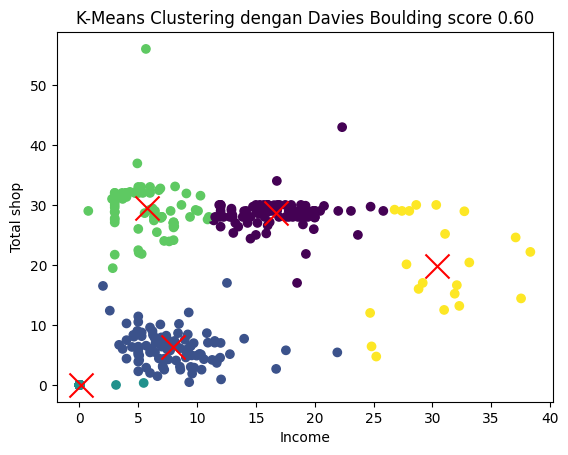

In [27]:
cluster_assignments = kmeans.labels_
plt.scatter(data[:, 0], data[:, 1], c=cluster_assignments, cmap='viridis')
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s=300, c='red', marker='x')
plt.xlabel('Income')
plt.ylabel('Total shop')
plt.title(f'K-Means Clustering dengan Davies Boulding score {silhouette_score(data, cluster_assignments):.2f}')
plt.show()

In [44]:
array1 = [2, 5, 6, None, 7]
array_base = [3, 5, 7, 1, 2]
array2 = [array_base[i] if val != None else None for i, val in enumerate(array1)]
array2

[3, 5, 7, None, 2]